In [11]:
import os
import json
import random
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
from sklearn import metrics
from IPython.display import Image
from sklearn.model_selection import train_test_split


In [12]:
dt = "/Users/ivan/Desktop/ALL/Data/CVmchar"

In [13]:
ix, iy = 25, 50

def fimg(img):
    return cv.resize(img, (ix, iy))

img = fimg(cv.imread(f"{dt}/mchar_train/018292.png"))
cv.imwrite("tmp.jpg", img)
Image("tmp.jpg", height=100, width=100)


In [14]:
N = 100
datax = []
datay = []

dtype = "mchar_train"

with open(f"{dt}/{dtype}.json", "r") as f:
    data = f.readlines()
json_file = data[0]
j_obj = json.loads(json_file)

heightl, widthl = [], []
data = []
for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:10000]):
    f1dti = j_obj[dti]
    img = cv.imread(f"{dt}/{dtype}/{dti}")
    _, x, _ = img.shape
    
    for n in [1, 2, 3, 4, 5]:
        x1, x2 = x//5*(n-1), x//5*n
        nimg = img[:,x1:x2]

        for top, height, left, width, label in zip(
            f1dti["top"], f1dti["height"], f1dti["left"], f1dti["width"], f1dti["label"]):
            top, height, left, width, label = int(top), int(height), int(left), int(width), int(label)
            top, height, left, width = max(top,0), max(height,0), max(left,0), max(width,0)

            if x1 <= left and (left+width) <= x2:
                # cv.imwrite(f"tmp_{label}.jpg", fimg(nimg))

                datax.append(fimg(nimg))
                datay.append(label)
            elif random.choice(range(N)) == 0:
                # cv.imwrite(f"tmp_-1.jpg", fimg(nimg))

                datax.append(fimg(nimg))
                datay.append(-1)


100%|██████████| 10000/10000 [00:04<00:00, 2010.21it/s]


In [15]:
len(datax), len(datay)

(7715, 7715)

In [16]:
%time rx = np.array(datax, dtype=np.float32)

%time ry = np.array(datay, dtype=np.int32)
print(pd.value_counts(ry))


CPU times: user 31.4 ms, sys: 24.5 ms, total: 55.9 ms
Wall time: 59.9 ms
CPU times: user 901 µs, sys: 15 µs, total: 916 µs
Wall time: 963 µs
 1    1563
-1    1007
 2     866
 3     666
 4     638
 5     597
 0     541
 7     524
 6     490
 8     423
 9     400
dtype: int64


In [17]:
m_x = rx
m_y = ry

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def tf_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(iy, ix, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        loss=tf.keras.losses.MAE, 
        optimizer="adam", 
        metrics=['accuracy']
    )
    return model

model = tf_model()
print(model.summary())

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('>', end='')
        if epoch % 100 == 0: 
            print('')

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
%time history = model.fit(m_x,m_y,epochs=EPOCHS,validation_split=0.5,verbose=0,callbacks=[early_stop, PrintDot()])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 23, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 11, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 9, 64)         18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 4, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 2, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

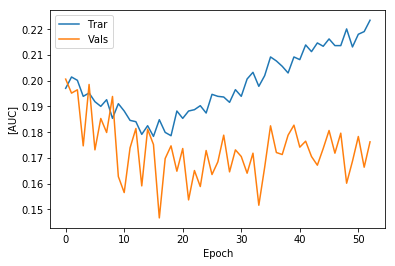

In [18]:
import matplotlib.pyplot as plt


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('[AUC]')
    plt.plot(hist['epoch'], hist['accuracy'], label='Trar')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Vals')
    plt.legend()

plot_history(history)


In [19]:
m1, m2 = 0, 0

dtype = "mchar_train"

with open(f"{dt}/{dtype}.json", "r") as f:
    data = f.readlines()
json_file = data[0]
j_obj = json.loads(json_file)

for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:100]):
    f1dti = j_obj[dti]
    img = cv.imread(f"{dt}/{dtype}/{dti}")
    _, x, _ = img.shape
    result = ""
    
    for n in [1, 2, 3, 4, 5]:
        x1, x2 = x//5*(n-1), x//5*n
        nimg = img[:,x1:x2]
        
        img0 = fimg(nimg)
        img0 = np.array([img0], dtype=np.float32)
        result += str(max(int(model.predict(img0)[0][0]), 0))
    
    r1 = str(int(result))
    r2 = "".join([str(_) for _ in f1dti["label"]])
    
    m1 += 1 if r1 == r2 else 0  
    m2 += 1

"%s, %d, %d, %.6f" % (dtype, m1, m2, m1/m2)


100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


'mchar_train, 0, 100, 0.000000'

In [20]:
m1, m2 = 0, 0

dtype = "mchar_val"

with open(f"{dt}/{dtype}.json", "r") as f:
    data = f.readlines()
json_file = data[0]
j_obj = json.loads(json_file)

for dti in tqdm(os.listdir(f"{dt}/{dtype}")[:100]):
    f1dti = j_obj[dti]
    img = cv.imread(f"{dt}/{dtype}/{dti}")
    _, x, _ = img.shape
    result = ""
    
    for n in [1, 2, 3, 4, 5]:
        x1, x2 = x//5*(n-1), x//5*n
        nimg = img[:,x1:x2]
        
        img0 = fimg(nimg)
        img0 = np.array([img0], dtype=np.float32)
        result += str(max(int(model.predict(img0)[0][0]), 0))
    
    r1 = str(int(result))
    r2 = "".join([str(_) for _ in f1dti["label"]])
    
    m1 += 1 if r1 == r2 else 0  
    m2 += 1

"%s, %d, %d, %.6f" % (dtype, m1, m2, m1/m2)

100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


'mchar_val, 0, 100, 0.000000'